**Analysis of job offers from the NoFluffJobs wbsite**

Job positions included in the analysis: data analyst, data engineer, data scientist.

https://nofluffjobs.com/pl

In [13]:
import requests
import time
from bs4 import BeautifulSoup
import glob, os
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt

**NFJ downloader**

A function that returns the html code of the page

In [1]:
job_positions = ["data analyst", "data engineer", "data scientist"]

for job_position in job_positions:
    for i in range(1, 10):
        url = f"https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27{job_position}%27&page={i}"
        page = requests.get(url)
        print(page.url)
        soup = BeautifulSoup(page.text, 'html.parser')
        result = soup.select_one('#undefinedJobs > span')
        if result is None:
            print('No offers')
            break
        else:
            print('There are job offers')

        with open(f'data/raw/{job_position}_{i}.html', mode='w', encoding='utf-8') as file:
            file.write(page.text)
        time.sleep(2)

https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20analyst%27&page=1
There are job offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20analyst%27&page=2
There are job offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20analyst%27&page=3
No offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20engineer%27&page=1
There are job offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20engineer%27&page=2
There are job offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20engineer%27&page=3
There are job offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20engineer%27&page=4
There are job offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20engineer%27&page=5
There are job offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20engineer%27&page=6
No offers
https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27data%20scientist%27&page=1
There are job offers
https://nofluf

A function that retrieves data from a website

In [8]:
def download_job_title(offer):
    return offer.select_one('nfj-posting-item-title > div > div > h3').text.strip()

def download_employer(offer):
    return offer.select_one('nfj-posting-item-title > div > span').text.strip()

def download_technology(offer):
    technology = offer.select_one('div.posting-info.position-relative.md\:tw-flex.tw-grow.tw-items-center.ng-star-inserted > nfj-posting-item-tags > common-posting-item-tag > object > a')
    if technology:
        return technology.text.strip()
    else:
        return
    
def download_city(offer):
    return offer.select_one('div.posting-info.position-relative.md\:tw-flex.tw-grow.tw-items-center.ng-star-inserted > div.tw-inline-flex.tw-items-center.tw-text-sm.tw-ml-auto.tw-relative > nfj-posting-item-city > div > span.tw-text-ellipsis.tw-inline-block.tw-overflow-hidden.tw-whitespace-nowrap.lg\:tw-max-w-\[100px\].tw-text-right').text.strip()

def dowlnoad_salary(offer):
    salary = offer.select_one('div.posting-info.position-relative.md\:tw-flex.tw-grow.tw-items-center.ng-star-inserted > nfj-posting-item-tags > span').text
    salary = salary.replace("\u00a0", "")
    salary_split = salary.split(' ')

    if len(salary_split) == 4:
        answer = {'low': int(salary_split[1]), 'high': int(salary_split[1]), 'currency': salary_split[-1].strip()}
    else:
        answer = {'low': int(salary_split[1]), 'high': int(salary_split[4]), 'currency': salary_split[-1].strip()}
    
    return answer
    
def download_from_file(path1):
    name = os.path.basename(path1)
    return name.split('_')[0]



result = []

for file2 in glob.glob(r"data\raw\*.html"):
    with open (file2, encoding = 'utf-8') as file3:
        soup = BeautifulSoup(file3,"html.parser")
        offer_list = soup.select(".list-container > a")

        for offer in offer_list:
            info  = {
                'name': download_job_title(offer),
                'company': download_employer(offer),
                'technology': download_technology(offer),
                'job':  download_from_file(file2),
                'location': download_city(offer),
                'salary': dowlnoad_salary(offer)
            }
            result.append(info)

#print(result)

df = pd.json_normalize(result)
df.to_csv(fr'data/processed/job_offers_au_{datetime.date.today()}.csv', sep=';', encoding='utf-8', index=False)
print('------------')


------------


**Data processing**

In [2]:
import pandas as pd
import re

In [3]:
df_raw = pd.read_csv('data/interim/job_offers_au_2023-10-11.csv',
    sep=';',
    encoding='UTF-8'
)
df_raw.head()

,name,company,technology,job,location,salary.low,salary.high,salary.currency
0,Data Analyst,DENTONS BUSINESS SERVICES EMEA,NaN,data analyst,Zdalnie,12300,18400,PLN
1,Senior Business Analyst / Data Operating Model,Diverse CG,NaN,data analyst,Warszawa,21000,24360,PLN
2,Marketing Data Senior Analyst/Marketing Automa...,AI REV,NaN,data analyst,Zdalnie,22680,31584,PLN
3,Remote Data Analyst/Data Engineering Team Lead,DataFeedWatch by Cart,NaN,data analyst,Zdalnie,17000,23000,PLN
4,Marketing Data Analyst,Murka Games Limited,NaN,data analyst,Zdalnie,10647,14906,PLN


In [4]:
df = df_raw.copy()

df['name'] = df['name'].str.lower()
df.rename(columns={'salary.low':'salary_low', 'salary.high' : 'salary_high', 'salary.currency' : 'salary_currency'}, inplace = True)
df.head(1)

,name,company,technology,job,location,salary_low,salary_high,salary_currency
0,data analyst,DENTONS BUSINESS SERVICES EMEA,NaN,data analyst,Zdalnie,12300,18400,PLN


In [5]:
df['salary_avg'] = (df['salary_low']+df['salary_high'])/2

In [6]:
df['location'].unique()

array(['Zdalnie', 'Warszawa', 'Budapest', 'Prague', 'Krakow', 'Katowice',
       'Kraków', 'Poznań', 'Wrocław', 'Warsaw', 'Trójmiasto'],
      dtype=object)

In [8]:
df.loc[df['location'].isin(['Warszawa', 'Warsaw']), 'location'] = 'Warszawa'
df.loc[df['location'].isin(['Kraków', 'Krakow']), 'location'] = 'Kraków'

In [10]:
df['is_senior'] = 0
df.loc[df['name'].apply(lambda x: True if re.match('(?i)(senior)', x) else False), 
'is_senior'] = 1

In [11]:
df = df.loc[df['salary_currency'] == 'PLN']

In [12]:
df.to_csv('data/processed/job_offers.csv',
    sep=';',
    encoding='UTF-8',
    index=False)

**Data Analysis**

In [14]:
df = pd.read_csv(
    'data/processed/job_offers.csv',
    sep=';',
    encoding='UTF-8')
df.head()

,name,company,technology,job,location,salary_low,salary_high,salary_currency,salary_avg,is_senior
0,data analyst,DENTONS BUSINESS SERVICES EMEA,NaN,data analyst,Zdalnie,12300,18400,PLN,15350.0,0
1,senior business analyst / data operating model,Diverse CG,NaN,data analyst,Warszawa,21000,24360,PLN,22680.0,1
2,marketing data senior analyst/marketing automa...,AI REV,NaN,data analyst,Zdalnie,22680,31584,PLN,27132.0,0
3,remote data analyst/data engineering team lead,DataFeedWatch by Cart,NaN,data analyst,Zdalnie,17000,23000,PLN,20000.0,0
4,marketing data analyst,Murka Games Limited,NaN,data analyst,Zdalnie,10647,14906,PLN,12776.5,0


job
data analyst      23
data engineer     83
data scientist    19
dtype: int64


<Axes: xlabel='job'>

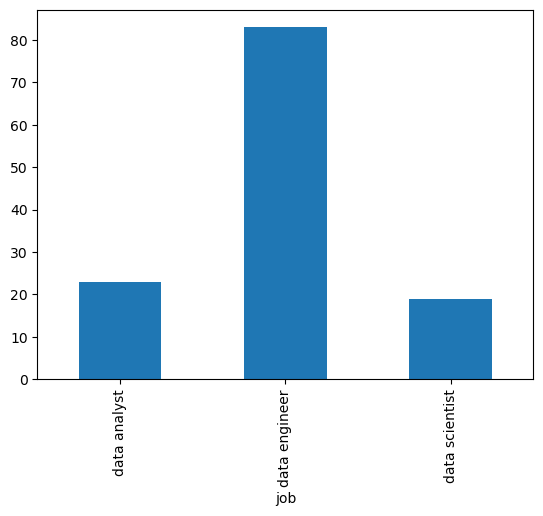

In [15]:
job_offers = df.groupby(by=['job']).size()

print(job_offers)
job_offers.plot.bar()

<Axes: xlabel='location,job'>

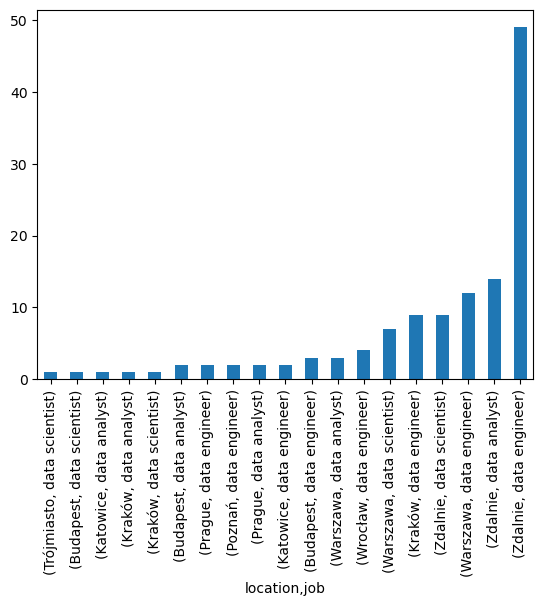

In [18]:
offers_by_city = df.groupby(by = ['location', 'job']).size()
offers_by_city

offers_by_city.sort_values().plot.bar()

                  salary_avg  count
job                                
data analyst    17099.869565     23
data scientist  21960.921053     19
data engineer   24011.734940     83


array([[<Axes: title={'center': 'salary_avg'}, xlabel='job'>,
        <Axes: title={'center': 'count'}, xlabel='job'>]], dtype=object)

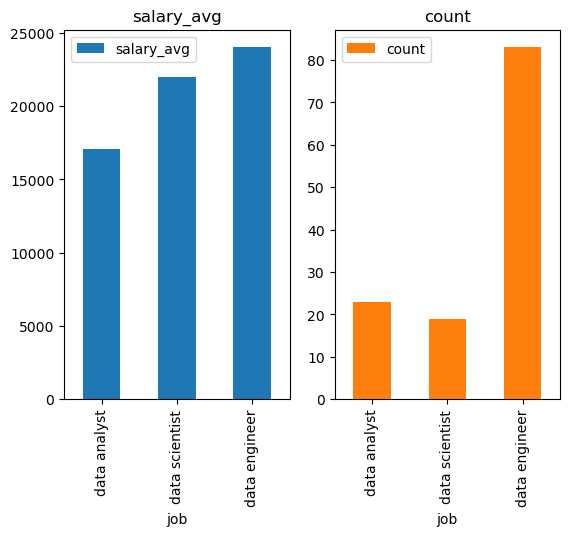

In [19]:
offer_salary = df.groupby(by=['job']).agg({'salary_avg': 'mean', 'name': 'count'})
offer_salary.sort_values(by=['salary_avg'], inplace=True)
offer_salary.rename(columns={'name':'count'}, inplace=True)

print(offer_salary)
offer_salary.plot(subplots=True, layout=(1, 2), kind='bar')

In [22]:
offer_salary_by_city = df.groupby(by=['location']).agg({'salary_avg': 'mean', 'name': 'count'})
offer_salary_by_city.sort_values(by=['salary_avg'], inplace=True)
offer_salary_by_city.rename(columns={'name':'count'}, inplace=True)

offer_salary_by_city

,salary_avg,count
location,,
Budapest,14995.416667,6
Katowice,16113.333333,3
Prague,17480.000000,4
Trójmiasto,18060.000000,1
Poznań,21690.000000,2
Zdalnie,22637.541667,72
Warszawa,23318.181818,22
Wrocław,23787.500000,4
Kraków,26891.181818,11


<Axes: xlabel='location'>

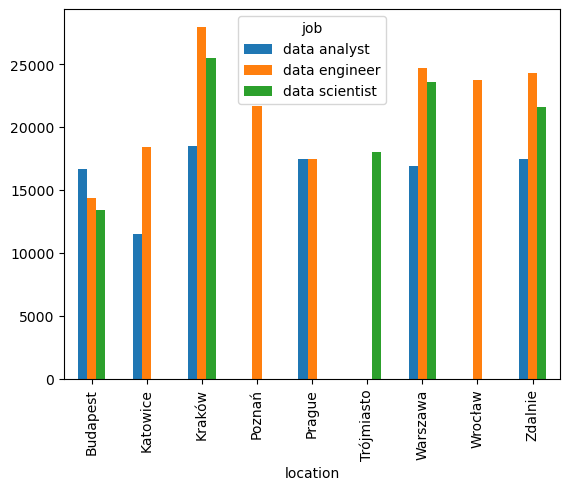

In [24]:
df.pivot_table(index='location', columns='job', values='salary_avg').plot(kind='bar')

In [25]:
salary_by_senior = df.groupby(by=['job', 'is_senior']).agg({'salary_avg': 'mean', 'name': 'count'})
salary_by_senior

salary_avg  name
job            is_senior                    
data analyst   0          15599.941176    17
               1          21349.666667     6
data engineer  0          23047.822581    62
               1          26857.571429    21
data scientist 0          19415.000000     8
               1          23812.500000    11